In [208]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [ ]:
movie_df = pd.read_csv('ada-2024-project-correlationeqcausation/cache/data.csv')

In [211]:
# Grouping by title
movie_unique_df = movie_df.groupby('title').first().reset_index()

In [212]:
# Removing movies without imdb ratings
movie_unique_with_rating_df = movie_unique_df[movie_unique_df['averageRating'].notna()]


In [213]:
# Extracting nominated and movies and not nominated movies 
nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated']]
not_nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated'] == False]
assert nominated.shape[0] + not_nominated.shape[0] == movie_unique_with_rating_df.shape[0]

In [214]:
# We exclude all movies with fewer than 30 reviews. There are no movies with oscar nominated actors with fewer than 30 reviews.
# This is based on a rule of thumb to exlude outliers / low confidence values 
excluded = not_nominated[not_nominated['numVotes'] < 30]
print('Excluded: ', len(excluded))
not_nominated = not_nominated[not_nominated['numVotes'] > 30]
nominated = nominated[nominated['numVotes'] > 30]

Excluded:  2062


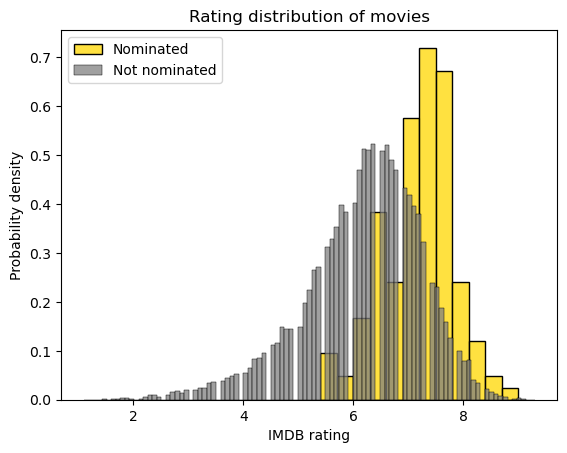

In [215]:
# Empirical CDF for nominated and not nominated 

sns.histplot(nominated, x="averageRating", stat = 'density', color = 'gold',label ='Nominated')
sns.histplot(not_nominated, x="averageRating", stat="density", color = 'grey', label = 'Not nominated')

plt.title('Rating distribution of movies')
plt.xlabel('IMDB rating')
plt.ylabel('Probability density')
plt.legend()
plt.show()


These empirical distributions look different. We use a two sample Kolmogorov-Smirnov test to test if they are different. The null hypothesis is that the observations come from the same distribution. We reject the null hypothesis if the p-value < 0.05.

In [216]:
stats.kstest(nominated['averageRating'], not_nominated['averageRating'])

KstestResult(statistic=0.4751828374799345, pvalue=3.8459869470555553e-29, statistic_location=6.5, statistic_sign=-1)

P-value = 3.831382878105564e-29. This is small enough to safely reject the null hypothesis. We conclude that the distributions are in fact different distributions. 

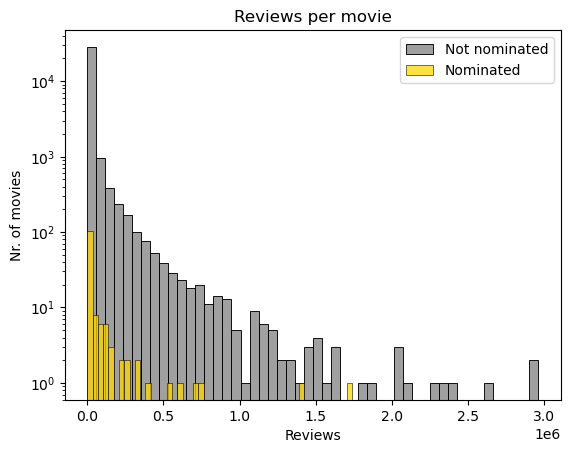

In [222]:
# Plotting reviews per IMDB reviews per movie 
sns.histplot(not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

Share of not nominated movies with fewer than 10 000 reviews 81.05 %
Share of nominated with fewer than 10 000 reviews 49.64 %


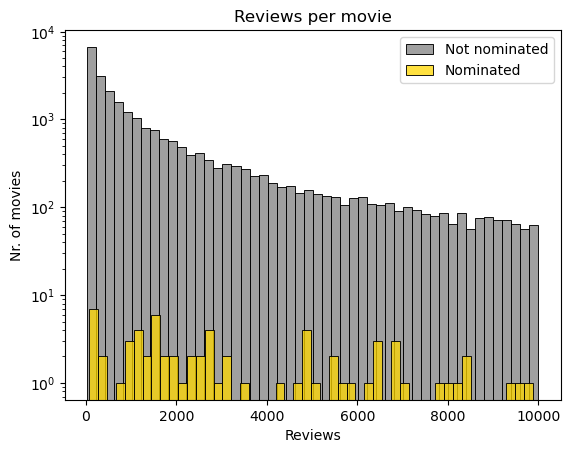

In [237]:
# As per the plot above, most movies with nominated actors have fewer than 500 000 reviews.
# We zoom in and look at the movies with few reviews. 

lim_not_nominated = not_nominated[not_nominated['numVotes'] < 10000]
lim_nominated = nominated[nominated['numVotes'] < 10000]

print('Share of not nominated movies with fewer than 10 000 reviews', round(len(lim_not_nominated)/len(not_nominated)*100,2), '%')
print('Share of nominated with fewer than 10 000 reviews', round(len(lim_nominated)/(len(nominated))*100,2),  '%')

sns.histplot(lim_not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(lim_nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')

plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

We can see that most movies with relatively few review are not nominated. 

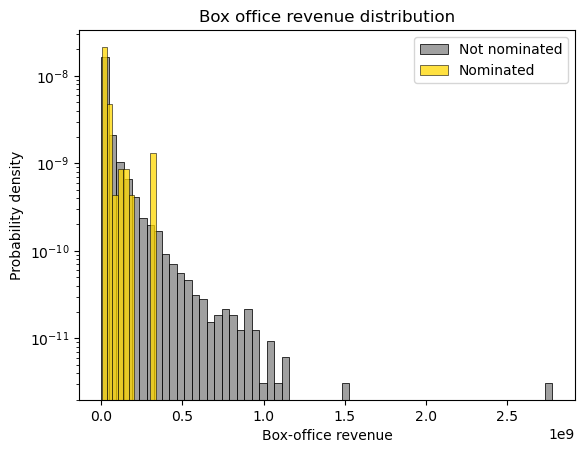

In [ ]:
sns.histplot(not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 10)

plt.title('Box office revenue distribution')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Notice that the above plot is a probability distribution and that the y axis is in log scale. We are suprised since all movies with nominated actors does not seem to be the ones with the highest revenue. To investigate this we look into movies with lower box-office revenue. 

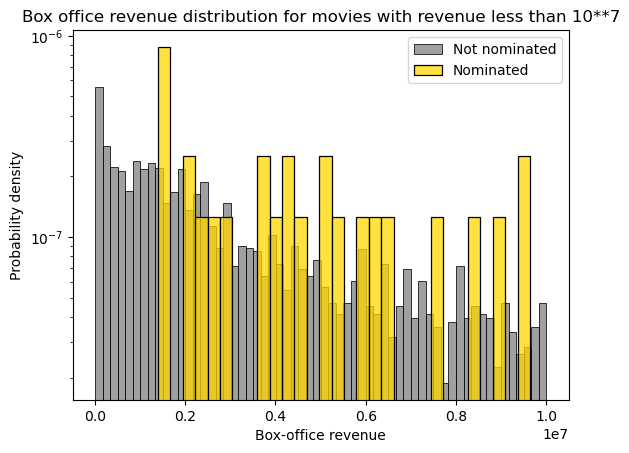

In [236]:
lim_not_nominated = not_nominated[not_nominated['box_office_revenue'] < 10**7]
lim_nominated = nominated[nominated['box_office_revenue'] < 10**7]

sns.histplot(lim_not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(lim_nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 30)

plt.title('Box office revenue distribution for movies with revenue less than 10**7')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()


We can see that movies with nominated actors have revenue in an interval. They neither the movies with the highest revenue, or the movies with the lowest revenue. 

In [242]:
nominated = movie_df[movie_df['oscar_nominated'] == True]
nominated['freebase_movie_id'].value_counts()

freebase_movie_id
/m/0bj25      5
/m/04j13sx    5
/m/03mr85     5
/m/0bm2g      5
/m/0hvvf      5
             ..
/m/01vksx     1
/m/04x0wp     1
/m/015gv2     1
/m/05mxns9    1
/m/015wmg     1
Name: count, Length: 1010, dtype: int64

In [260]:
oscar_nomination_count_per_movie = nominated.groupby(["freebase_movie_id"])['freebase_movie_id'].count().to_frame().rename(columns={"freebase_movie_id": "count"})

<Axes: xlabel='count', ylabel='Density'>

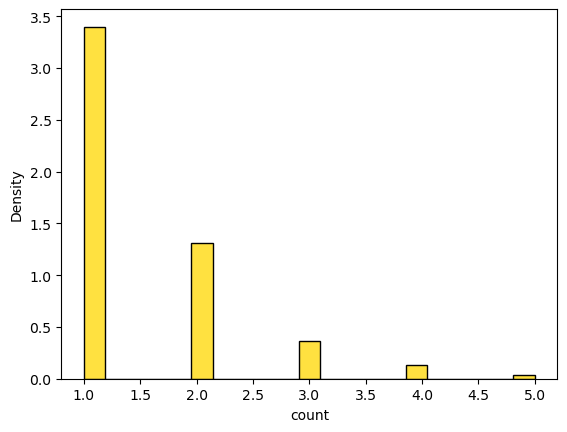

In [261]:
sns.histplot(oscar_nomination_count_per_movie, x="count", stat = 'density', color = 'gold',label ='Nominated')


In [287]:
# Defining some variables for analysis. 
nr_movies = len(movie_unique_df)
nr_nom_movies = len(nominated.groupby('freebase_movie_id'))
nr_nominations = len(nominated)

zero_nom_movies = nr_movies - nr_nom_movies
one_nom_movies = len(oscar_nomination_count_per_movie[oscar_nomination_count_per_movie['count'] == 1])

In [288]:
# What is the probablity a movie will have a nominated actor? 
print('Likelyhood of a movie having a nominated actor: ', round(nr_nom_movies/nr_movies*100, 3), '%')

# Given that a movie has a nominated actor, what is the probablity that it will have atleast one more nominated actor? 
print('Probablity that a movie with a nominated actor will have atleast one more nominated actor', round((nr_nom_movies - one_nom_movies)/(nr_nom_movies)*100, 3), '%')


Likelyhood of a movie having a nominated actor:  1.698 %
Probablity that a movie with a nominated actor will have atleast one more nominated actor 35.248 %


<Axes: xlabel='count', ylabel='Density'>

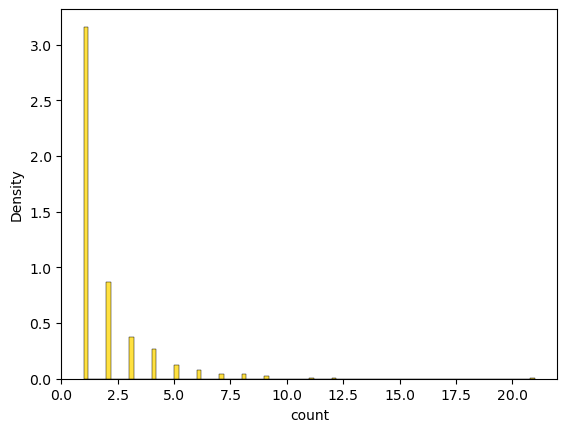

In [295]:
oscar_nomination_per_actor_name = nominated.groupby(["actor_name"])['actor_name'].count().to_frame().rename(columns={"actor_name": "count"})
sns.histplot(oscar_nomination_per_actor_name, x="count", stat = 'density', color = 'gold',label ='Nominated')
